# 135 Group 9 project draft

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
import pyspark.sql.functions as f
import pyspark.sql.types as typ

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("group 9 project") \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

## Data Import and Processing

### 1. Reading Video Categories

In [2]:
category_ca = spark.read.json('CA_category_id.json', multiLine=True)
category_ca.printSchema()

root
 |-- etag: string (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- etag: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- kind: string (nullable = true)
 |    |    |-- snippet: struct (nullable = true)
 |    |    |    |-- assignable: boolean (nullable = true)
 |    |    |    |-- channelId: string (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |-- kind: string (nullable = true)



In [3]:
ca_category = category_ca.select('items.id', 'items.snippet.title')\
    .withColumn('temp', f.arrays_zip('id','title'))\
    .drop('id','title')\
    .withColumn('ex', explode('temp')).drop('temp')\
    .select('ex.id','ex.title')\
    .rdd

# ca_category.collect()

In [4]:
category_us = spark.read.json('US_category_id.json', multiLine=True)
category_us.printSchema()

root
 |-- etag: string (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- etag: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- kind: string (nullable = true)
 |    |    |-- snippet: struct (nullable = true)
 |    |    |    |-- assignable: boolean (nullable = true)
 |    |    |    |-- channelId: string (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |-- kind: string (nullable = true)



In [5]:
us_category = category_us.select('items.id', 'items.snippet.title')\
    .withColumn('temp', f.arrays_zip('id','title'))\
    .drop('id','title')\
    .withColumn('ex', explode('temp')).drop('temp')\
    .select('ex.id','ex.title')\
    .rdd

# us_category.collect()

#### Category difference check

We are curious whether the IDs have the same corresponding category for both CA and US

In [6]:
ca_category.subtract(us_category).collect()

[]

In [6]:
us_category.subtract(ca_category).collect()

[Row(id='29', title='Nonprofits & Activism')]

As the result, **us_category_rdd** includes all categories from **ca_category_rdd**. In this case, we use **us category rdd** as our reference of categories.

In [7]:
cat_ref = us_category
cat_ref.collect()

[Row(id='1', title='Film & Animation'),
 Row(id='2', title='Autos & Vehicles'),
 Row(id='10', title='Music'),
 Row(id='15', title='Pets & Animals'),
 Row(id='17', title='Sports'),
 Row(id='18', title='Short Movies'),
 Row(id='19', title='Travel & Events'),
 Row(id='20', title='Gaming'),
 Row(id='21', title='Videoblogging'),
 Row(id='22', title='People & Blogs'),
 Row(id='23', title='Comedy'),
 Row(id='24', title='Entertainment'),
 Row(id='25', title='News & Politics'),
 Row(id='26', title='Howto & Style'),
 Row(id='27', title='Education'),
 Row(id='28', title='Science & Technology'),
 Row(id='29', title='Nonprofits & Activism'),
 Row(id='30', title='Movies'),
 Row(id='31', title='Anime/Animation'),
 Row(id='32', title='Action/Adventure'),
 Row(id='33', title='Classics'),
 Row(id='34', title='Comedy'),
 Row(id='35', title='Documentary'),
 Row(id='36', title='Drama'),
 Row(id='37', title='Family'),
 Row(id='38', title='Foreign'),
 Row(id='39', title='Horror'),
 Row(id='40', title='Sci-Fi

In [9]:
print('We have different types of categories = {}'.format(cat_ref.count()))

We have different types of categories = 32


### 2. Reading Video Data

We decide to use 'textFile' instead of 'read.csv' because we think rdd is more easier for us to origanize and filiter.

In [8]:
CA_video = sc.textFile('CAvideos.csv')
header1 = CA_video.first()

CA_data = CA_video.filter(lambda row: row != header1) \
                .map(lambda row: [str(elem) for elem in row.split(',')])\
                .map(lambda row: row[0:15])\
                .filter(lambda row: len(row) == 15)
#remove description column, and save only completed observations

#CA_data.take(5)
#CA_data.count()

In [9]:
US_video = sc.textFile('USvideos.csv')
header2 = US_video.first()

US_data = US_video.filter(lambda row: row != header2) \
                .map(lambda row: [str(elem) for elem in row.split(',')])\
                .map(lambda row: row[0:15])\
                .filter(lambda row: len(row) == 15)
#remove description column, and save only the completed observations

#US_data.take(5)
#US_data.count()

We're thinking to combine two datasets as a whole. But before that, we need to check whether the columns of two datasets are identical.

In [10]:
# variables identical check

header1 == header2


True

In this case, we believe that it's okay to combine the datasets.

In [11]:
#combining two datasets

all_video = CA_data.union(US_data)

CA_data.count()+US_data.count() == all_video.count()


True

In [12]:
all_video.count()

81854

After combining the two datasets, we have a new datasets with 81,854 observations.

#### Create a schema to pass to a Spark DataFrame

In [13]:
fields = [
    *[
        typ.StructField(h, typ.StringType(), True)
        for h in header1.split(',')
    ]
]
# fields

In [14]:
schema = typ.StructType(fields[0:15])
schema

StructType(List(StructField(video_id,StringType,true),StructField(trending_date,StringType,true),StructField(title,StringType,true),StructField(channel_title,StringType,true),StructField(category_id,StringType,true),StructField(publish_time,StringType,true),StructField(tags,StringType,true),StructField(views,StringType,true),StructField(likes,StringType,true),StructField(dislikes,StringType,true),StructField(comment_count,StringType,true),StructField(thumbnail_link,StringType,true),StructField(comments_disabled,StringType,true),StructField(ratings_disabled,StringType,true),StructField(video_error_or_removed,StringType,true)))

In [15]:
video_frame = spark.createDataFrame(all_video, schema)
video_frame.cache()

DataFrame[video_id: string, trending_date: string, title: string, channel_title: string, category_id: string, publish_time: string, tags: string, views: string, likes: string, dislikes: string, comment_count: string, thumbnail_link: string, comments_disabled: string, ratings_disabled: string, video_error_or_removed: string]

In [16]:
type(video_frame)

pyspark.sql.dataframe.DataFrame

## Data Cleaning

First, we need to check whetehr the data are read properly, or in other words, whether the data are placed in the correct column. For example, whether the data is 'True' or 'False' in the comments_disabled column.

In [17]:
# reading properly check
temp_frame = video_frame.collect()
incorrect_index =[]

for i in range(video_frame.count()):
    if temp_frame[i][12] != 'True' and temp_frame[i][12] != 'False':
        incorrect_index.append(i)

len(incorrect_index)

8941

We know that there are 8,941 of observations are read incorrectly, which is just a small portion in our whole dataset. Therefore, we decide to remove all of them.

In [18]:
# remove incorrectly reading data

temp_adjusted =[]

for i in range(video_frame.count()):
    if temp_frame[i][12] == 'True' or temp_frame[i][12] == 'False':
        temp_adjusted.append(temp_frame[i])

video_rdd = sc.parallelize(temp_adjusted)
# type(video_rdd)
video_rdd.take(2)

[Row(video_id='n1WpP7iowLc', trending_date='17.14.11', title='"Eminem - Walk On Water (Audio) ft. Beyoncé"', channel_title='"EminemVEVO"', category_id='10', publish_time='2017-11-10T17:00:03.000Z', tags='"Eminem"|"Walk"|"On"|"Water"|"Aftermath/Shady/Interscope"|"Rap"', views='17158579', likes='787425', dislikes='43420', comment_count='125882', thumbnail_link='https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg', comments_disabled='False', ratings_disabled='False', video_error_or_removed='False'),
 Row(video_id='0dBIkQ4Mz1M', trending_date='17.14.11', title='"PLUSH - Bad Unboxing Fan Mail"', channel_title='"iDubbbzTV"', category_id='23', publish_time='2017-11-13T17:00:00.000Z', tags='"plush"|"bad unboxing"|"unboxing"|"fan mail"|"idubbbztv"|"idubbbztv2"|"things"|"best"|"packages"|"plushies"|"chontent chop"', views='1014651', likes='127794', dislikes='1688', comment_count='13030', thumbnail_link='https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg', comments_disabled='False', ratings_disabled='Fals

In [19]:
video_frame.count() - len(incorrect_index) == video_rdd.count()

True

In [20]:
video_rdd.count()

72913

After removing the observations that were read incorrectly, our dataset contains 72913 observations. 

In [21]:
# final categories data, we use:
cat_ref

# final video data, we use:
video_rdd

ParallelCollectionRDD[66] at readRDDFromFile at PythonRDD.scala:262

## Exploratory Data Analysis

### 1. Describtion of numerical columns

In [22]:
num_feature = ['views','likes','dislikes','comment_count']

video_rdd.toDF().select(num_feature).summary().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|             views|             likes|         dislikes|     comment_count|
+-------+------------------+------------------+-----------------+------------------+
|  count|             72913|             72913|            72913|             72913|
|   mean|1723750.5126109198|57707.640557925195|2883.798883601004| 6978.537709324812|
| stddev| 5730979.903881168| 191982.5930008822|25828.51052881144|32139.279911420137|
|    min|              1000|                 0|                0|                 0|
|    25%|          185267.0|            3638.0|            143.0|             533.0|
|    50%|          500224.0|           13346.0|            442.0|            1586.0|
|    75%|         1342583.0|           40973.0|           1399.0|            4644.0|
|    max|             99999|             99990|             9994|             99980|
+-------+------------------+------------------+-----------------+

From the table, we can tell that:
1. the average number of views of a trending video is *1,723,750*, and the median is about *500,224*. Since mean is much greater than median, we can tell the distribution of views is left-skwed distribution;
2. the average number of likes of a trending video is *57,707*, but the the average number of dislikes of a trending video is only *2,883*;
3. the average number of comment is *6,978*.

##### Check how many videos have 1 million views or less

In [25]:
(video_rdd.toDF().select('views').filter(f.col('views') < 1e6).count()\
                     / video_rdd.toDF().select('views').count())*100


68.04959335097993

##### Check how many videos have 1.5 million views or less

In [26]:
(video_rdd.toDF().select('views').filter(f.col('views') < 1.5e6).count()\
                     / video_rdd.toDF().select('views').count())*100

77.30171574342025

##### Check how many videos have 5 million views or less

In [27]:
(video_rdd.toDF().select('views').filter(f.col('views') < 5e6).count()\
                     / video_rdd.toDF().select('views').count())*100

93.76517219151592

Therefore, there are:
1. about 68% videos have 1 million views or less,
2. about 77% videos have 1.5 million views or less, and
3. about 94% videos have 5 million views or less.

Which means:
1. about 32% videos have 1 million views or more,
2. about 23% videos have 1.5 million views or more, and
3. about 6% videos have 5 million views or more.

### 2. Describtion of non-numerical columns

In [28]:
non_num_feature = ['video_id','trending_date','title','channel_title','publish_time','tags','thumbnail_link']

video_rdd.toDF().select(non_num_feature).describe().show()


+-------+-----------+-------------+--------------------+--------------+--------------------+--------------------+--------------------+
|summary|   video_id|trending_date|               title| channel_title|        publish_time|                tags|      thumbnail_link|
+-------+-----------+-------------+--------------------+--------------+--------------------+--------------------+--------------------+
|  count|      72913|        72913|               72913|         72913|               72913|               72913|               72913|
|   mean|       null|         null|                null|          null|                null|                null|                null|
| stddev|       null|         null|                null|          null|                null|                null|                null|
|    min|--45ws7CEN0|     17.01.12|"!! THIS VIDEO IS...|"#AndresSTyle"|2006-07-23T08:24:...|"#2018impact"|"#y...|https://i.ytimg.c...|
|    max|zzjNCiCqiOs|     18.31.05|"🚨Active Shooter...|

#### Unique check

Checking the uniqueness, which we're interested in the variables of **video_id, trending_date,** and **title**.

In [29]:
print('video_id uniqueness:')
print(video_rdd.toDF().select('video_id').distinct().count())
print('trending_date uniqueness:')
print(video_rdd.toDF().select('trending_date').distinct().count())
print('title uniqueness:')
print(video_rdd.toDF().select('title').distinct().count())

video_id uniqueness:
24685
trending_date uniqueness:
205
title uniqueness:
24895


From the table and the uniqueness above, we can tell that:
1. the trending date of videos are collected from 12.01.2017 to 05.31.2018, which are **205 days of trending**;
2. there are 24,685 different videos on the trending list, and the total count of 72,913 is saying that some of the videos on the trending list **more than one day**;
3. the uniqueness of title is greater than the uniqueness of videos id. The most likely reason is that some of the videos have different titles (in other words, the titles of the videos are changed while the videos are on the trending list).

##### Different title check

In [30]:
uniqueness1 = video_rdd.toDF().select('video_id','title').groupby(['video_id','title']).count()\
                .where('count > 1').sort('count', ascending=False)
uniqueness1.select('video_id').groupby('video_id').count().where('count > 1')\
                .sort('count', ascending=False).show()

+-----------+-----+
|   video_id|count|
+-----------+-----+
|8WbxbqwdWog|    3|
|QA2fKoT6Sig|    2|
|4oYYVrEFWE8|    2|
|fuoCUfdqZFI|    2|
|P_If9xMyl10|    2|
|xLtYmhj-0Kg|    2|
|OXVm3fhYsEo|    2|
|0ufNmUyf2co|    2|
|ogfYd705cRs|    2|
|xVU8nEIsapY|    2|
|JpR_JaVguBk|    2|
|5NaAwSpswJE|    2|
|8C8pRDetZr8|    2|
|3lgcBZdMZxM|    2|
|D2mxKEa2xmA|    2|
|m7Ege1M5Pag|    2|
|e-0YnJlFPeE|    2|
|iLZwZX39FXU|    2|
|gjQ1Brofle8|    2|
|R9OHn5ZF4Uo|    2|
+-----------+-----+
only showing top 20 rows



The table shows it is true that some videos have different titles. Let's show an example below.

In [31]:
different_title = video_rdd.toDF().select('video_id','title')\
                            .filter(f.col('video_id') == '8WbxbqwdWog')
different_title.show(truncate = False)

+-----------+------------------------------------------------------------------------------------+
|video_id   |title                                                                               |
+-----------+------------------------------------------------------------------------------------+
|8WbxbqwdWog|"Camera Goes on Japanese Sushi Conveyor Belt  - TROUBLE!!!"                         |
|8WbxbqwdWog|"Camera Goes on Japanese Sushi Conveyor Belt  - TROUBLE!!!"                         |
|8WbxbqwdWog|"Camera Goes on Japanese Sushi Conveyor Belt - TROUBLE!!!"                          |
|8WbxbqwdWog|"Camera Goes on Japanese Sushi Conveyor Belt - TROUBLE!!!"                          |
|8WbxbqwdWog|"Camera Goes on Japanese Sushi Conveyor Belt Shows Beautiful Slice of Japanese Life"|
|8WbxbqwdWog|"Camera Goes on Japanese Sushi Conveyor Belt Shows Beautiful Slice of Japanese Life"|
+-----------+------------------------------------------------------------------------------------+



So we can see the video *8WbxbqwdWog* uses different titles.

### Counting the frequency of video by categories

In [32]:
video_rdd.toDF().groupby('category_id').count().sort('count', ascending=False).show()

+-----------+-----+
|category_id|count|
+-----------+-----+
|         24|21186|
|         10| 8904|
|         23| 6825|
|         22| 6500|
|         26| 5895|
|         25| 5478|
|          1| 3913|
|         17| 3849|
|         28| 3279|
|         27| 2481|
|         20| 2032|
|         15| 1150|
|         19|  633|
|          2|  587|
|         29|  121|
|         43|   74|
|         30|    6|
+-----------+-----+



From the table, we know that the top three categories are 24, 10, and 23, which according to the category reference, we know they're **Entertainment, Music,** and **Comedy**.

###### exporting dataset for graphing purpose.

In [33]:
#video_rdd.toDF().write.format('com.databricks.spark.csv').save('VIDEOcsv.csv')

------------------

According to our research question, we're only interested in **Entertainment and Comedy**.

In [23]:
# subset data for Comedy and Entertainment videos

video_rdd2 = video_rdd.filter(lambda row: row[4] == '23' or row[4] == '24')
video_rdd2.count()
#video_rdd2.take(5)

28011

##### tags organization

In [24]:
from pyspark.sql import Row
tags = video_rdd2.map(lambda row: row[6]).map(lambda row: row.split('|'))\
                .map(lambda row: [row[i].replace('"','') for i in range(len(row))])\
                .map(lambda x: Row(x))
tags.take(3)

[<Row(['plush', 'bad unboxing', 'unboxing', 'fan mail', 'idubbbztv', 'idubbbztv2', 'things', 'best', 'packages', 'plushies', 'chontent chop'])>,
 <Row(['ryan', 'higa', 'higatv', 'nigahiga', 'i dare you', 'idy', 'rhpc', 'dares', 'no truth', 'comments', 'comedy', 'funny', 'stupid', 'fail'])>,
 <Row(['Funny Moments', 'Montage video games', 'gaming', 'Vanoss', 'VanossGaming', 'Gameplay', 'Secret', 'Puncake', 'Parody', 'Comedy', 'Remix', 'Epic', 'Trolling', 'Xbox One', 'MultiplayerPS4', 'Funtage', 'superhero school', 'vanoss superhero school', 'superhero', 'scool', 'school', 'super hero', 'vanoss gaming school', 'doc', 'documentary'])>]

In [25]:
# Convert rdd to df
df_subset = video_rdd2.toDF()

In [26]:
# Use RegexTokenizer to help turn tags into features
from pyspark.ml.feature import RegexTokenizer
import pyspark.sql.functions as f

rt = RegexTokenizer(inputCol = 'tags', outputCol = 'tags2', pattern = '\|') # split tags by |

df_subset = df_subset.withColumn("tags", f.translate(f.col("tags"), '"', "").alias('tags')) # Remove quoatations around tags

df_subset = rt.transform(df_subset)


df_subset.select('tags','tags2').show(3) # thus tags 2 is tokenized and ready to be used as features



+--------------------+--------------------+
|                tags|               tags2|
+--------------------+--------------------+
|plush|bad unboxin...|[plush, bad unbox...|
|ryan|higa|higatv|...|[ryan, higa, higa...|
|Funny Moments|Mon...|[funny moments, m...|
+--------------------+--------------------+
only showing top 3 rows



In [27]:
# unique videos for training our model in comedy & entertainment
df_subset.select('video_id').distinct().count() 

10223

## Engineered Features

### Time of day posted

In [28]:
from pyspark.sql.functions import when, substring
from pyspark.sql.types import IntegerType

# Set the publish_time to Morning(0) (0400-1000), noon(1) (1100 - 1800), evening(1900-0459)(2)
# Note: given we have sliced only by HOUR, each 00 implies 00-59 above
# substring(x, start pos, # characters)
df_subset2 = df_subset.withColumn('hour', substring(df_subset.publish_time, 12, 2)) # slice time: Hour
df_subset3 = df_subset2.withColumn('hour', df_subset2.hour.cast(IntegerType())) # cast string time to int

# assign time variables
# create 'day_segment' to model morning (0), afternoon(1), Evening(2)
df_subset4 = df_subset3.withColumn('day_segment', 
                   when((df_subset3.hour >= 4) & (df_subset3.hour <= 10), 0)
                   .when((df_subset3.hour >= 11) & (df_subset3.hour <= 18), 1)
                   .when((df_subset3.hour > 18) | (df_subset3.hour < 4), 2))

# expand factors with oneHotEncoder Note: Previous version used integer values 0 1 2, 
# Note: however given the low number of factors OneHotEncoder will work better
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="day_segment", outputCol="day_segment2")
df_subset4 = encoder.fit(df_subset4).transform(df_subset4)


In [29]:
df_subset4.select('day_segment', 'day_segment2').distinct().show() # all values assigned properly/ no unkown/missing

+-----------+-------------+
|day_segment| day_segment2|
+-----------+-------------+
|          0|(2,[0],[1.0])|
|          1|(2,[1],[1.0])|
|          2|    (2,[],[])|
+-----------+-------------+



### NUMBER OF DAYS TRENDING: Response variable

In [30]:
# NOTE: CA and US 'days' are unique and if a video trends in both countries on the same day, that is considered 2 days
# this adds a bias or weight to things commercial in both countries as we are looking to penetrate the Canadian market as well
import pyspark.sql.functions as f
from pyspark.sql import Window
# Create # of days trending variable
w = Window.partitionBy('video_id')
df5 = df_subset4.withColumn('days_trending', f.count('video_id').over(w))

In [31]:
df5.select('video_id', 'days_trending').show(25)

+-----------+-------------+
|   video_id|days_trending|
+-----------+-------------+
|-H90GPnH1q8|            4|
|-H90GPnH1q8|            4|
|-H90GPnH1q8|            4|
|-H90GPnH1q8|            4|
|4V-yu1qYDnE|            2|
|4V-yu1qYDnE|            2|
|6vi6yQtntdE|            2|
|6vi6yQtntdE|            2|
|7fKNp-oc5dM|            1|
|8XL4oDhwj8M|            1|
|8cj5pmZzF3M|            3|
|8cj5pmZzF3M|            3|
|8cj5pmZzF3M|            3|
|9XaUPRA6ZAI|            1|
|9_LIP7qguYw|            5|
|9_LIP7qguYw|            5|
|9_LIP7qguYw|            5|
|9_LIP7qguYw|            5|
|9_LIP7qguYw|            5|
|9mpwlkc2a5s|            1|
|A4mzB2PTo-E|            4|
|A4mzB2PTo-E|            4|
|A4mzB2PTo-E|            4|
|A4mzB2PTo-E|            4|
|AQ3dPvVPXyc|            1|
+-----------+-------------+
only showing top 25 rows



In [32]:
# remove duplicate rows as our model is not interested in the day over day changes to likes, views, comments etc
# Note: something trending for multiple days is likely not affected by the day segment posted, however could still be significant in the initial trending process
df6 = df5.dropDuplicates(['video_id'])
df6.select('video_id','days_trending').show(10)

+-----------+-------------+
|   video_id|days_trending|
+-----------+-------------+
|-H90GPnH1q8|            4|
|4V-yu1qYDnE|            2|
|6vi6yQtntdE|            2|
|7fKNp-oc5dM|            1|
|8XL4oDhwj8M|            1|
|8cj5pmZzF3M|            3|
|9XaUPRA6ZAI|            1|
|9_LIP7qguYw|            5|
|9mpwlkc2a5s|            1|
|A4mzB2PTo-E|            4|
+-----------+-------------+
only showing top 10 rows



In [33]:
# create subset with variables we are interested in
df7 = df6.select('video_id','days_trending','day_segment','tags', 'tags2', 'title','day_segment2')
df7.show(10)

+-----------+-------------+-----------+--------------------+--------------------+--------------------+-------------+
|   video_id|days_trending|day_segment|                tags|               tags2|               title| day_segment2|
+-----------+-------------+-----------+--------------------+--------------------+--------------------+-------------+
|-H90GPnH1q8|            4|          2|The Walking Dead ...|[the walking dead...|"The Walking Dead...|    (2,[],[])|
|4V-yu1qYDnE|            2|          2|Alonzo Lerone|Alo...|[alonzo lerone, a...|"I Tried Making I...|    (2,[],[])|
|6vi6yQtntdE|            2|          2|Late|Night|with|S...|[late, night, wit...|"Trump Supporters...|    (2,[],[])|
|7fKNp-oc5dM|            1|          1|new|eritrean|dram...|[new, eritrean, d...|"New Eritrean Dra...|(2,[1],[1.0])|
|8XL4oDhwj8M|            1|          1|makeup puns|make ...|[makeup puns, mak...|"THE BEST MAKEUP ...|(2,[1],[1.0])|
|8cj5pmZzF3M|            3|          1|the|disaster|arti...|[the

### df7 has all relevant data prior to NLP process 

Note: df11 has words/ words filtered with just " removed from titles

## Exploratory Data Analysis on Subset

### 1. Describtion of Response Variable

In [34]:
df7.select('days_trending').summary().show()

+-------+-----------------+
|summary|    days_trending|
+-------+-----------------+
|  count|            10223|
|   mean|2.739998043627115|
| stddev|3.327651573867273|
|    min|                1|
|    25%|                1|
|    50%|                2|
|    75%|                3|
|    max|               34|
+-------+-----------------+



### 2. Describtion of Categorical Variables

#### 1. variable day_segment

In [35]:
df7.groupBy('day_segment').count().show()

+-----------+-----+
|day_segment|count|
+-----------+-----+
|          1| 4907|
|          2| 4182|
|          0| 1134|
+-----------+-----+



#### 2. variable title

In [36]:
from pyspark.sql.functions import split
df_EDA = df7.withColumn("title", f.translate(f.col("title"), '"', "").alias('title'))

In [37]:
title_list = df_EDA.select("title").rdd.flatMap(lambda x: x) 

In [38]:
title_list.take(5)

["The Walking Dead 8x08 Ending Scene Carl was bitten Season 8 Episode 8 HD How It's Gotta Be",
 'I Tried Making INVISIBLE Potato Chips | Tutorial FAIL | Alonzo Lerone',
 'Trump Supporters Think He Deserves the Nobel Peace Prize: A Closer Look',
 'New Eritrean Drama 2018 Nabrana Part 25',
 'THE BEST MAKEUP PUNS!']

In [39]:
title_words = title_list.flatMap(lambda x: x.split())

In [40]:
title_words.take(20)

['The',
 'Walking',
 'Dead',
 '8x08',
 'Ending',
 'Scene',
 'Carl',
 'was',
 'bitten',
 'Season',
 '8',
 'Episode',
 '8',
 'HD',
 'How',
 "It's",
 'Gotta',
 'Be',
 'I',
 'Tried']

In [41]:
title_wordcounts = title_words.map(lambda x: (x, 1)) \
                  .reduceByKey(lambda x,y:x+y) \
                  .map(lambda x:(x[1],x[0])) \
                  .sortByKey(False)

In [42]:
title_wordcounts.take(25)

[(3353, '-'),
 (2845, '|'),
 (1467, 'The'),
 (1153, 'Episode'),
 (639, '2018'),
 (550, 'the'),
 (457, '&'),
 (403, 'to'),
 (383, 'of'),
 (382, 'A'),
 (354, '10'),
 (350, 'and'),
 (348, 'on'),
 (346, 'الحلقة'),
 (339, 'a'),
 (337, 'with'),
 (325, '2'),
 (296, 'Drama'),
 (293, 'To'),
 (290, 'in'),
 (268, 'TV'),
 (258, '2017'),
 (242, 'Season'),
 (236, 'With'),
 (234, 'Trailer')]

From this we can see that the top five most frequent words that were used in the titles of the videos on the trending list are 'Episode', '2018', 'الحلقة', 'Drama' and 'TV' ignoring the words like "The", "a".

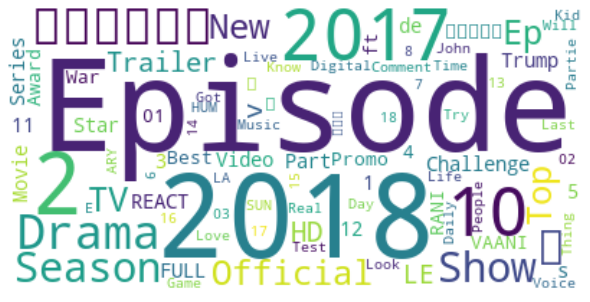

In [55]:
#from wordcloud import WordCloud, STOPWORDS 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
stopwords = set(STOPWORDS)

title_wordlist = title_words.collect()

title_wordstring = (" ").join(title_wordlist)

wordcloud = WordCloud(width = 400, height = 200, random_state = 1,
background_color ='white', collocations = False,
#stopwords = stopwords,
max_words = 100, include_numbers = True,
min_font_size = 10).generate(title_wordstring)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
#save the wordcloud as an image
#wordcloud.to_file("first_review.png")

In [ ]:
# import sys
# print(sys.executable)
# /conda/bin/python -m pip install wordcloud

In [ ]:
# wordcloud = WordCloud(width = 800, height = 800, 
#                 background_color ='white', 
#                 stopwords = stopwords, 
#                 min_font_size = 10).generate(comment_words)

#### 3. variable tags

In [43]:
tags_list = df_EDA.select("tags2").rdd.flatMap(lambda x: x).flatMap(lambda x: x)  

In [57]:
tags_list.take(5)

['the walking dead 8x08 carl was bitten season 8 episode 8 hd',
 'the walking dead',
 'the walking dead 8x08',
 'the walking dead 8x08 promo',
 'the walking dead season 8']

In [44]:
tags_counts = tags_list.map(lambda x: (x, 1)) \
                  .reduceByKey(lambda x,y:x+y) \
                  .map(lambda x:(x[1],x[0])) \
                  .sortByKey(False)

In [59]:
tags_counts.take(10)

[(1644, 'funny'),
 (1379, 'comedy'),
 (629, 'talk show'),
 (606, 'entertainment'),
 (553, 'humor'),
 (482, 'television'),
 (439, 'celebrity'),
 (409, 'comedian'),
 (391, 'reaction'),
 (368, 'music')]

The top 5 most used tags for videos in category Entertainment and Comedy are "funny", 'comedy','talk show','entertainment' and 'humor'.

## Model Building

### Base Model

#### Pipelines / Base Model Cleaning

In [45]:
# Base model pipeline: for 1gram/words
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# tokenizer to split string into word list
tokenizer = Tokenizer(inputCol = 'title', outputCol = 'words') # need to remove " and other symbols

# Remove filler words (i the etc)
sw = StopWordsRemover(inputCol = 'words', outputCol = 'words_filtered')

# no ngrams with base pipe
#ngram

# create vectorizer: No minDF used in original
vect = CountVectorizer(inputCol="words_filtered", outputCol="counts")


# create pipe object to be used to adjust data
pipe1 = Pipeline(stages = [tokenizer, sw, vect]) 

In [46]:
# remove filler from title string: could be more, these are the ones I found
df8 = df7.withColumn("title", f.translate(f.col("title"), '"|:', "").alias('title')) #translates every instance of " | or : into nothing even when part of word
#Example: ["hey:, this, |that] = [hey, this, that]

# tokenize the title with filler removed - Then apply stopwordsRemover
# Note this was needed as our 'words' included ", such that "the was not being removed by stopwords at the beggining and end of our titles
df9 = pipe1.fit(df8).transform(df8)

# Verify their are no words unexpected
df9.select('words','words_filtered').show(5,False)

+-------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------+
|words                                                                                                        |words_filtered                                                                      |
+-------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------+
|[the, walking, dead, 8x08, ending, scene, carl, was, bitten, season, 8, episode, 8, hd, how, it's, gotta, be]|[walking, dead, 8x08, ending, scene, carl, bitten, season, 8, episode, 8, hd, gotta]|
|[i, tried, making, invisible, potato, chips, , tutorial, fail, , alonzo, lerone]                             |[tried, making, invisible, potato, chips, , tutorial, fail, , alonzo, lerone]       |
|[trump, suppor

In [57]:
df9.select('counts').show(5,False) # 18915 'words' being tracked by model

+-----------------------------------------------------------------------------------------------------------+
|counts                                                                                                     |
+-----------------------------------------------------------------------------------------------------------+
|(18915,[2,13,64,82,285,322,382,603,1657,3939,5923,13794],[1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(18915,[0,532,720,778,1128,1894,2311,2738,4138,4189],[2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])            |
|(18915,[21,87,224,759,2681,2728,3153,4416,4429],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                     |
|(18915,[3,8,17,22,216,241,426],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])                                              |
|(18915,[28,343,6811],[1.0,1.0,1.0])                                                                        |
+-----------------------------------------------------------------------------------------------------------+
only showi

### Base Model:

In [47]:
# split our data for model building
training, test = df9.randomSplit([0.7, 0.3], seed=333)


In [59]:
%%time
from pyspark.ml.regression import LinearRegression


lr_base = LinearRegression(featuresCol = 'counts', labelCol = 'days_trending')
lr = lr_base.fit(training)
lrPred = lr.transform(test)


In [87]:
lrPred.show(3)

+-----------+-------------+-----------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+------------------+
|   video_id|days_trending|day_segment|                tags|               tags2|               title| day_segment2|               words|      words_filtered|              counts|        prediction|
+-----------+-------------+-----------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+------------------+
|8cj5pmZzF3M|            3|          1|the|disaster|arti...|[the, disaster, a...|The Disaster Arti...|(2,[1],[1.0])|[the, disaster, a...|[disaster, artist...|(18915,[98,991,10...|1.3370372265238881|
|9mpwlkc2a5s|            1|          2|jimmy|jimmy kimme...|[jimmy, jimmy kim...|Jimmy Kimmel Resp...|    (2,[],[])|[jimmy, kimmel, r...|[jimmy, kimmel, r...|(18915,[198,478,7...| 3.940860413111435|
|Atdw

In [97]:
%%time
# taken/modified from HW/lecture
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'rmse')

# Mean square
mse = eval.evaluate(lrPred, {eval.metricName: 'mse'})
print('MSE: %.3f' % mse)

#Adjusted R-Squared
eval2 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) on test data = %g" % eval2.evaluate(lrPred))

MSE: 40.768
R Squared (R2) on test data = -2.9739


From the Above we see that our base model, including only the words from the title produces an MSE of 40.76, this is largely a useless model given the distribution of days trending below

In [60]:
# display rough distribution of days trending
import pyspark.sql.functions as f
from pyspark.sql import Window

# moch histogram of days trending

w2 = Window.partitionBy('days_trending')
df7.withColumn('days_trending_count', f.count('days_trending').over(w2)).select('days_trending','days_trending_count').distinct().show(50) # 33 unique values

+-------------+-------------------+
|days_trending|days_trending_count|
+-------------+-------------------+
|           26|                  3|
|           29|                  1|
|           19|                 14|
|           22|                  7|
|            7|                179|
|           34|                  1|
|           32|                  1|
|           25|                  4|
|            6|                236|
|            9|                117|
|           27|                  6|
|           17|                 24|
|           28|                  2|
|           33|                  2|
|            5|                292|
|            1|               5096|
|           10|                 69|
|            3|                983|
|           12|                 60|
|            8|                129|
|           11|                 74|
|            2|               2192|
|            4|                486|
|           13|                 72|
|           18|             

### Model 2: Base model + day segment

In [62]:
# add in more predictors (assemble) ( Apply before training split)
assembler = VectorAssembler(inputCols = [x for x in df9.columns if x in ['day_segment','counts']], outputCol = "features")

# transform df9
df10 = assembler.transform(df9).select('days_trending','features','day_segment')

In [65]:
df10.show(8, False) # note our count is incremented by 1, added 1 more variable, index is 0 for day_segment

+-------------+-----------------------------------------------------------------------------------------------------------------+-----------+
|days_trending|features                                                                                                         |day_segment|
+-------------+-----------------------------------------------------------------------------------------------------------------+-----------+
|4            |(18916,[0,3,14,65,83,286,323,383,604,1658,3940,5924,13795],[2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|2          |
|2            |(18916,[0,1,533,721,779,1129,1895,2312,2739,4139,4190],[2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])            |2          |
|2            |(18916,[0,22,88,225,760,2682,2729,3154,4417,4430],[2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                     |2          |
|1            |(18916,[0,4,9,18,23,217,242,427],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                                              |1          |
|1    

In [63]:
%%time
from pyspark.ml.regression import LinearRegression
# split our data for model building
training2, test2 = df10.randomSplit([0.7, 0.3], seed=333)

# create model
lr_mod2 = LinearRegression(featuresCol = 'features', labelCol = 'days_trending')
lr2 = lr_mod2.fit(training2)
lrPred2 = lr2.transform(test2)

CPU times: user 2.9 s, sys: 1.56 s, total: 4.46 s
Wall time: 13min


In [66]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'rmse')

# Mean square
mse2 = eval.evaluate(lrPred2, {eval.metricName: 'mse'})
print('MSE: %.3f' % mse2)

#Adjusted R-Squared
eval2 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) on Base Model with Day Segment = %g" % eval2.evaluate(lrPred2))

MSE: 46.708
R Squared (R2) on Base Model with Day Segment = -3.36078


Thus we can see through the MSE that our model has been made worse through with day segments

In [94]:
lrPred2.select('prediction').show(15) # MSE 46 is much worse, observing prediction values shows negatives which we would never want
# these negative values are from the 'nature' of regression fitting a straight line

+-------------------+
|         prediction|
+-------------------+
| 2.4712121235229105|
|  1.653124006876224|
|-3.2141362953866635|
|  3.753315776676674|
|   1.60292377650973|
| 2.8473661492944697|
|  2.209976176671075|
| 3.2657983772138888|
| 11.379470682931924|
|  6.349259426075786|
|-0.9628113842613324|
| -6.548162202855322|
| -4.197044241814408|
| 1.5399381898681899|
|-1.1413019712710009|
+-------------------+
only showing top 15 rows



### Model 3: Introducing Ngrams

In [49]:
# taken from: https://stackoverflow.com/questions/38839924/how-to-combine-n-grams-into-one-vocabulary-in-spark, modified for our dataframe + added tokenizer
# NOTE: Perhaps we should 'normalize' titles/words further, tokenizer appears to cast all to lower case automatically
# if we want more than 5grams, increment n+=1
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler, Tokenizer
from pyspark.ml import Pipeline


def build_ngrams(inputCol="title", n=5):
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(3, n + 1)
    ]
    # No min_df used in initial model
    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i))
        for i in range(3, n + 1)
    ]

    assembler = [VectorAssembler(
        inputCols=["{0}_counts".format(i) for i in range(3, n + 1)],
        outputCol="ngram_title"
    )]

    return Pipeline(stages=  ngrams + vectorizers + assembler)


In [50]:
df_nlp = build_ngrams().fit(df9).transform(df9) # Note: df9 not necessary as we are inputing the 'words' column
# We input the words column so no stopwords have been applied in this model but our filter (removing "|:) has been applied on the words

In [51]:
%%time
# model with just 3gram, 4gram, 5gram
from pyspark.ml.regression import LinearRegression
# split our data for model building
training3, test3 = df_nlp.randomSplit([0.7, 0.3], seed=333)

# create model
lr_mod3 = LinearRegression(featuresCol = 'ngram_title', labelCol = 'days_trending')
lr3 = lr_mod3.fit(training3)
lrPred3 = lr3.transform(test3)

# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'rmse')

# Mean square
mse3 = eval.evaluate(lrPred3, {eval.metricName: 'mse'})
print('MSE: %.3f' % mse3)

#Adjusted R-Squared: Use eval2
eval2 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2)  = %g" % eval2.evaluate(lrPred3))

MSE: 10.062
R Squared (R2)  = 0.019198
CPU times: user 2.36 s, sys: 1.24 s, total: 3.6 s
Wall time: 1h 28min 12s


Thus we see that without using the stopwords remover, and simply looking at ngrams up to 5 our model has greatly improved

Noting that this model took an excessive amount of time to train given the lack of cleaning on the features

### Model 4: Exploring NLP

In [52]:
# Create model with minDF to clean features and reduce model building time

from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler, Tokenizer
from pyspark.ml import Pipeline


def build_ngrams2(inputCol="title", n=5):
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]
    #  minDF=0.01: "ignore terms that appear in less than 1% of the documents"
    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i), minDF = 0.01)
        for i in range(1, n + 1)
    ]

    assembler = [VectorAssembler(
        inputCols=["{0}_counts".format(i) for i in range(1, n + 1)],
        outputCol="ngram_title"
    )]

    return Pipeline(stages=  ngrams + vectorizers + assembler)

In [53]:
df11 = df7.withColumn("title", f.translate(f.col("title"), '"', "").alias('title')) # just want to remove artifacts from string conversion, |; may be relavent to model


In [54]:
df11 = pipe1.fit(df11).transform(df11) # Note: pipe1 tokenizes the title and filters the words, then creates counts on single filtered words

In [55]:
df11.show(3) 

+-----------+-------------+-----------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+
|   video_id|days_trending|day_segment|                tags|               tags2|               title|day_segment2|               words|      words_filtered|              counts|
+-----------+-------------+-----------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+
|-H90GPnH1q8|            4|          2|The Walking Dead ...|[the walking dead...|The Walking Dead ...|   (2,[],[])|[the, walking, de...|[walking, dead, 8...|(19326,[2,13,63,8...|
|4V-yu1qYDnE|            2|          2|Alonzo Lerone|Alo...|[alonzo lerone, a...|I Tried Making IN...|   (2,[],[])|[i, tried, making...|[tried, making, i...|(19326,[1,569,722...|
|6vi6yQtntdE|            2|          2|Late|Night|with|S...|[late, night, wit...|Trump Supporters ...|   

In [56]:
df_NLP2 = build_ngrams2().fit(df11).transform(df11)

In [57]:
df_NLP2.select('ngram_title').show(3) # 111 features from all ngrams kept

+--------------------+
|         ngram_title|
+--------------------+
|(111,[2,3,24,39],...|
|(111,[1,29],[2.0,...|
|(111,[2,5,40],[1....|
+--------------------+
only showing top 3 rows



In [58]:
%%time
# model with all ngrams up to 5 and filtered to contain only words/phrases included in atleast 1% of observations
from pyspark.ml.regression import LinearRegression
# split our data for model building
training4, test4 = df_NLP2.randomSplit([0.6, 0.4], seed=333) # given size of dataset have elected a more even train/test split

# create model
lr_mod4 = LinearRegression(featuresCol = 'ngram_title', labelCol = 'days_trending')
lr4 = lr_mod4.fit(training4)
lrPred4 = lr4.transform(test4)

# Evalueate model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'rmse')

# Mean square
mse4 = eval.evaluate(lrPred4, {eval.metricName: 'mse'})
print('MSE: %.3f' % mse4)

#Adjusted R-Squared
eval4 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) = %g" % eval4.evaluate(lrPred4))

MSE: 9.585
R Squared (R2) = 0.0558613
CPU times: user 178 ms, sys: 80.1 ms, total: 259 ms
Wall time: 1min 12s


Thus by introducing minDF into our vector assembler we were able to reduce the number of features greatly while improving our MSE and vastly improving model Train time

### Model 5: NLP stopword exploration

In [59]:
# Pipeline: split which words (filtered/ not filtered) are used in ngrams
def build_ngrams_split(inputCol="title", n=5):
    
    ngrams = [
        NGram(n=i, inputCol='words_filtered' , outputCol="{0}_grams".format(i))
        for i in range(1, 3)
    ]
    
    ngrams2 = [
        NGram(n=i, inputCol='words' , outputCol="{0}_grams".format(i))
        for i in range(3, n+1)
    ] # use other column of unfiltered words for ngrams greater than 2: 'The fact is' holds more context than 'fact'
    
    #  minDF=0.01: "ignore terms that appear in less than 1% of the documents"
    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i), minDF = 0.01)
        for i in range(1, n + 1)
    ]

    assembler = [VectorAssembler(
        inputCols=["{0}_counts".format(i) for i in range(1, n + 1)],
        outputCol="ngram_title"
    )]

    return Pipeline(stages=  ngrams + ngrams2 + vectorizers + assembler)

In [60]:
df_NLP3 = build_ngrams_split().fit(df11).transform(df11) # NOTE: df11 includes :| and other characters initially filtered

In [61]:
df_NLP3.select('title','2_grams','3_grams','4_grams','5_grams').show(3) # notice lack of stopwords for n < 3

+--------------------+--------------------+--------------------+--------------------+--------------------+
|               title|             2_grams|             3_grams|             4_grams|             5_grams|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|The Walking Dead ...|[walking dead, de...|[the walking dead...|[the walking dead...|[the walking dead...|
|I Tried Making IN...|[tried making, ma...|[i tried making, ...|[i tried making i...|[i tried making i...|
|Trump Supporters ...|[trump supporters...|[trump supporters...|[trump supporters...|[trump supporters...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [62]:
%%time
# model with all ngrams up to 5 and filtered to contain only words/phrases included in atleast 1% of observations
from pyspark.ml.regression import LinearRegression
# split our data for model building
training5, test5 = df_NLP3.randomSplit([0.6, 0.4], seed=333) # given size of dataset have elected a more even train/test split

# create model
lr_mod5 = LinearRegression(featuresCol = 'ngram_title', labelCol = 'days_trending')
lr5 = lr_mod5.fit(training5)
lrPred5 = lr5.transform(test5)

# Evaluate Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'rmse')

# Mean square
mse5 = eval.evaluate(lrPred5, {eval.metricName: 'mse'})
print('MSE: %.3f' % mse5)

#Adjusted R-Squared
eval5 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2)  = %g" % eval5.evaluate(lrPred5))

MSE: 9.793
R Squared (R2)  = 0.0353693
CPU times: user 155 ms, sys: 101 ms, total: 256 ms
Wall time: 1min 9s


Our model MSE has slightly been increased, likely indicating that we removed useful information by removing the stopwords for ngrams < 3

## Model 6: feature expansion

In [63]:
# Pipeline: revert back to including stopwords for all n, and include day_segment2 
# day_segment was previously shown unhelpful but have been turned into a feature vector as there are only 3 options to further test
def build_ngrams_features(inputCol="title", n=5):
    
    ngrams = [
        NGram(n=i, inputCol='words' , outputCol="{0}_grams".format(i))
        for i in range(1, n+1)
    ]
    
   
    
    #  minDF=0.01: "ignore terms that appear in less than 1% of the documents"
    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i), minDF = 0.01)
        for i in range(1, n + 1)
    ]

    assembler = [VectorAssembler(
        inputCols=["{0}_counts".format(i) for i in range(1, n + 1)],
        outputCol="ngram_title"
    )]
    
    # other variables we would like to add into our model
    assembler2 = [VectorAssembler(
        inputCols = ['day_segment2','ngram_title'], 
        outputCol = 'features'
    )]

    return Pipeline(stages=  ngrams  + vectorizers + assembler + assembler2)

In [64]:
df_NLP4 = build_ngrams_features().fit(df11).transform(df11)

In [65]:
df_NLP4.select('features').show(1) # 113 features

+--------------------+
|            features|
+--------------------+
|(113,[4,5,26,41],...|
+--------------------+
only showing top 1 row



In [66]:
%%time
# model with all ngrams up to 5 and filtered to contain only words/phrases included in atleast 1% of observations
from pyspark.ml.regression import LinearRegression
# split our data for model building
training6, test6 = df_NLP4.randomSplit([0.6, 0.4], seed=333) # given size of dataset have elected a more even train/test split

# create model
lr_mod6 = LinearRegression(featuresCol = 'features', labelCol = 'days_trending')
lr6 = lr_mod6.fit(training6)
lrPred6 = lr6.transform(test6)

# Evauate Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'rmse')

# Mean square
mse6 = eval.evaluate(lrPred6, {eval.metricName: 'mse'})
print('MSE: %.3f' % mse6)

#Adjusted R-Squared
eval6 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) = %g" % eval6.evaluate(lrPred6))

MSE: 9.610
R Squared (R2) = 0.0534279
CPU times: user 165 ms, sys: 85.9 ms, total: 251 ms
Wall time: 1min 8s


Thus this shows that using the non-filtered words appears to be giving better accuracy and reitterates that our day_segment (even when turned to features from onehotEncoder) is misleading for our model

## Model 4.1: explore regression settings 
Given we have shown that adding in the day segment has not helped our model nor has using the filtered words, I will try and optimize MSE with internal settings

Will attempt to add more features (tags NLP) in future iterations

Note: Can use df_NLP2 for model building

In [68]:
%%time
# NOTE: When \lambda>0 (i.e. regParam >0) and \alpha=0 (i.e. elasticNetParam =0) , then the penalty is an L2 penalty. (ridge regression)
# Note: When \lambda>0 (i.e. regParam >0) and \alpha=1 (i.e. elasticNetParam =1), then the penalty is an L1 penalty. (lasso (variable selection))
# LinearRegresion(featuresCol = '', labelCol = '', maxIter=10, regParam=0.3,  elasticNetParam=0.8...)
# https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/regression.html

# model with all ngrams up to 5 and filtered to contain only words/phrases included in atleast 1% of observations
from pyspark.ml.regression import LinearRegression

# split our data for model building
training7, test7 = df_NLP2.randomSplit([0.6, 0.4], seed=333) 

# create model - Ridge regression
lr_mod7 = LinearRegression(featuresCol = 'ngram_title', labelCol = 'days_trending', maxIter = 10, regParam = 0.3, elasticNetParam = 0 )
lr7 = lr_mod7.fit(training7)
lrPred7 = lr7.transform(test7)

# Create model - lasso
lr_mod8 = LinearRegression(featuresCol = 'ngram_title', labelCol = 'days_trending',maxIter = 10, regParam = 0.3, elasticNetParam = 1)
lr8 = lr_mod8.fit(training7)
lrPred8 = lr8.transform(test7)


CPU times: user 203 ms, sys: 94.1 ms, total: 297 ms
Wall time: 1min 19s


In [69]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'rmse')

# Mean square
mse7 = eval.evaluate(lrPred7, {eval.metricName: 'mse'})
print('MSE ridge: %.3f' % mse7)

mse8 = eval.evaluate(lrPred8, {eval.metricName: 'mse'})
print('MSE lasso: %.3f' % mse8)

#Adjusted R-Squared
eval7 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) ridge = %g" % eval7.evaluate(lrPred7))


eval8 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) lasso = %g" % eval8.evaluate(lrPred8))


MSE ridge: 9.558
MSE lasso: 9.893
R Squared (R2) ridge = 0.0585086
R Squared (R2) lasso = 0.0255109


Thus from the above we can see that our ridge model outperformed our lasso model with these features, and further our ridge regression is marginally better than default MSE of 9.585

NOTE: if we had not included maxIter/ regParam both of these models MSE would have been 9.585 (same as the original)

## Model 6.2: Feature expansion continued

In [70]:
# Pipeline
def build_ngrams_features2(inputCol="title", n=5):
    
    ngrams = [
        NGram(n=i, inputCol='words' , outputCol="{0}_grams".format(i))
        for i in range(1, n+1)
    ]
    
   
    
    #  minDF=0.01: "ignore terms that appear in less than 1% of the documents"
    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i), minDF = 0.01)
        for i in range(1, n + 1)
    ]
    
    # vectorizer for tags
    tagv = [CountVectorizer(
        inputCol = 'tags2',
        outputCol = 'tags_count', minDF = 0.01
    )]

    assembler = [VectorAssembler(
        inputCols=["{0}_counts".format(i) for i in range(1, n + 1)],
        outputCol="ngram_title"
    )]
    
    # other variables we would like to add into our model
    assembler2 = [VectorAssembler(
        inputCols = ['day_segment2','ngram_title','tags_count'], 
        outputCol = 'features'
    )]

    return Pipeline(stages=  ngrams  + vectorizers + tagv + assembler + assembler2)

In [71]:
df_NLP5 = build_ngrams_features2().fit(df11).transform(df11)

In [72]:
df_NLP5.select('features').show(3) # 297 features, up from 113 without tags under the same minDF criteria for tags and title ngrams/words

+--------------------+
|            features|
+--------------------+
|(297,[4,5,26,41],...|
|(297,[3,31,114,12...|
|(297,[4,7,42,113,...|
+--------------------+
only showing top 3 rows



In [73]:
# This is incase we don't want to train model below but need training8/test8 for other models
training8, test8 = df_NLP5.randomSplit([0.6, 0.4], seed=333)

In [74]:
%%time

# model with all title ngrams up to 5 and filtered and TAGS to contain only words/phrases included in atleast 1% of observations
from pyspark.ml.regression import LinearRegression

# split our data for model building
training8, test8 = df_NLP5.randomSplit([0.6, 0.4], seed=333) 

# create model - Ridge regression
lr_mod9 = LinearRegression(featuresCol = 'features', labelCol = 'days_trending', maxIter = 10, regParam = 0.3, elasticNetParam = 0 )
lr9 = lr_mod9.fit(training8)
lrPred9 = lr9.transform(test8)

# evaluate Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'rmse')

# Mean square
mse9 = eval.evaluate(lrPred9, {eval.metricName: 'mse'})
print('MSE ridge: %.3f' % mse9)

#Adjusted R-Squared
eval9 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) = %g" % eval9.evaluate(lrPred9))

MSE ridge: 9.479
R Squared (R2) = 0.0663276
CPU times: user 153 ms, sys: 108 ms, total: 261 ms
Wall time: 1min 12s


## Chisquare Selector

In [76]:
# ChiSquare Selection
from pyspark.ml.feature import ChiSqSelector
selector = ChiSqSelector(numTopFeatures=25, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="days_trending")

ChiSqresult = selector.fit(df_NLP5).transform(df_NLP5)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())


ChiSqSelector output with top 25 features selected


In [77]:
ChiSqresult.select('features', 'selectedFeatures').show(3)

+--------------------+--------------------+
|            features|    selectedFeatures|
+--------------------+--------------------+
|(297,[4,5,26,41],...|      (25,[1],[1.0])|
|(297,[3,31,114,12...|     (25,[12],[1.0])|
|(297,[4,7,42,113,...|(25,[2,12],[1.0,1...|
+--------------------+--------------------+
only showing top 3 rows



### Test selected features

In [78]:
%%time

# model with all title ngrams up to 5 and filtered and TAGS to contain only words/phrases included in atleast 1% of observations
# Chisquare filtered for only top 25 features
from pyspark.ml.regression import LinearRegression

# split our data for model building
training9, test9 = ChiSqresult.randomSplit([0.6, 0.4], seed=333) 

# create model - Ridge regression
lr_mod10 = LinearRegression(featuresCol = 'selectedFeatures', labelCol = 'days_trending', maxIter = 10, regParam = 0.3, elasticNetParam = 0 )
lr10 = lr_mod10.fit(training9)
lrPred10 = lr10.transform(test9)

#######

# Evalueate model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'rmse')

# Mean square
mse10 = eval.evaluate(lrPred10, {eval.metricName: 'mse'})
print('MSE ridge: %.3f' % mse10)

#Adjusted R-Squared
eval10 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) = %g" % eval10.evaluate(lrPred10))

MSE ridge: 9.602
R Squared (R2) = 0.05419
CPU times: user 170 ms, sys: 77.7 ms, total: 248 ms
Wall time: 1min 14s


Compression Via Chisquared appears to increase the MSE

## Random Forest Regression

default values

RandomForestRegressor(featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='variance', subsamplingRate=1.0, seed=None, numTrees=20, featureSubsetStrategy='auto', leafCol='', minWeightFractionPerNode=0.0, weightCol=None, bootstrap=True)

In [79]:
%%time
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'days_trending',seed = 333)

#Note: Using training 8 for model with tags and ngrams (mod 6.2)
# Train and test base model
rf1 = rf.fit(training8)
rfp1 = rf1.transform(test8)

# Evaluate Model
evaluator = RegressionEvaluator(labelCol="days_trending", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rfp1)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

#Adjusted R-Squared
eval10 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) = %g" % eval10.evaluate(rfp1))

Root Mean Squared Error (RMSE) on test data = 3.10032
R Squared (R2) = 0.0532232
CPU times: user 267 ms, sys: 121 ms, total: 388 ms
Wall time: 1min 58s


## Gradient boosted Tree Regression

default values

GBTRegressor(featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, subsamplingRate=1.0, checkpointInterval=10, lossType='squared', maxIter=20, stepSize=0.1, seed=None, impurity='variance', featureSubsetStrategy='all', validationTol=0.01, validationIndicatorCol=None, leafCol='', minWeightFractionPerNode=0.0, weightCol=None)

In [80]:
%%time
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

gbt = GBTRegressor(featuresCol = 'features', labelCol = 'days_trending', seed = 333, )

# Using train/test 8 
# train model/ make predicition on test data
gbt1 = gbt.fit(training8)
gbtp1 = gbt1.transform(test8)



# Evaluate model 
evaluator = RegressionEvaluator(
    labelCol="days_trending", predictionCol="prediction", metricName="rmse")
rmse2 = evaluator.evaluate(gbtp1)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse2)

# Adjusted R-Squared
eval10 = RegressionEvaluator(labelCol = 'days_trending', predictionCol = 'prediction', metricName = 'r2')
print("R Squared (R2) = %g" % eval10.evaluate(gbtp1))

Root Mean Squared Error (RMSE) on test data = 3.18205
R Squared (R2) = 0.00265264
CPU times: user 2.49 s, sys: 1.3 s, total: 3.79 s
Wall time: 7min 56s
